In [1]:
import os
import platform
import multiprocessing
import psutil
import subprocess

# Nom du processeur
cpu_name = subprocess.check_output("cat /proc/cpuinfo | grep 'model name' | head -1", shell=True).decode().strip().split(":")[1]


# Nombre total de cœurs logiques (threads)
threads = multiprocessing.cpu_count()

# Architecture
architecture = platform.machine()

# Mémoire RAM totale (en Go)
ram_total = round(psutil.virtual_memory().total / (1024 ** 3), 2)

# Infos affichées
print(f"Nom du CPU        : {cpu_name}")
print(f"Threads disponibles: {threads}")
print(f"Architecture       : {architecture}")
print(f"RAM totale         : {ram_total} Go")

Nom du CPU        :  QEMU Virtual CPU version 2.5+
Threads disponibles: 12
Architecture       : x86_64
RAM totale         : 30.65 Go


In [10]:
!python --version

Python 3.13.5


In [3]:
conda --version

conda 25.5.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
import glob
import os
import re
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Paths
DIRECTORY = "/home/user/datasets/resized_train_cropped/resized_train_cropped"  # parent folder with 18 subfolders
LABELS_FILE = "/home/user/datasets/trainLabels_cropped.csv"

# Load labels
labels_df = pd.read_csv(LABELS_FILE)
labels_dict = dict(zip(labels_df['image'], labels_df['level']))

# Collect all images in all subfolders
all_files = glob.glob(os.path.join(DIRECTORY, "**", "*.jpeg"), recursive=True)

images = []
labels = []
train_image_count = 0

for filepath in all_files:
    filename = os.path.basename(filepath)  # only keep filename
    if train_image_count < 1000:  # limit for testing
        img = load_img(filepath, target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)

        # match labels
        base_name = re.sub(r'\s*\(.*\)', '', filename.split('.')[0])
        label = labels_dict.get(base_name)

        if label is not None:
            labels.append(label)
            train_image_count += 1
        else:
            images.pop()  # skip if no label found

# Convert to arrays
images = np.array(images)
labels = np.array(labels)

# One-hot encoding
labels = to_categorical(labels, num_classes=5)

print("Loaded", images.shape[0], "images with labels")

2025-11-12 10:20:28.632686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded 1000 images with labels


In [3]:
images.shape

(1000, 256, 256, 3)

In [4]:
labels.shape

(1000, 5)

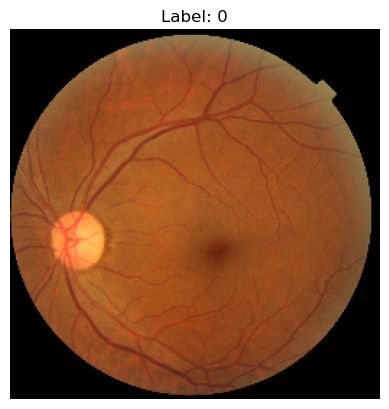

In [130]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(images[999])
plt.title(f"Label: {np.argmax(labels[999])}")  # Convert from one-hot to class index
plt.axis('off')
plt.show()

In [5]:
images_flat = images.reshape((images.shape[0], -1))  # Shape: (n_train, 256*256*3)

In [6]:
labels_flat = np.argmax(labels, axis=1)

In [7]:
images_flat.shape

(1000, 196608)

kmeans seq

In [134]:
class cust_K_Means(object):
    def __init__(self, n_clusters, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol  # Convergence tolerance
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Initialize centroids to zero"""
        return np.zeros((self.n_clusters, X.shape[1]))

    def _compute_distances(self, X, centers):
        """
        Vectorized distance computation - MUCH faster!
        Returns: (n_samples, n_clusters) array of distances
        """
        # Expand dimensions for broadcasting
        # X: (n_samples, n_features) -> (n_samples, 1, n_features)
        # centers: (n_clusters, n_features) -> (1, n_clusters, n_features)
        distances = np.sqrt(((X[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
        return distances

    def _assign_clusters(self, X, centers):
        """Assign each point to nearest cluster - VECTORIZED"""
        distances = self._compute_distances(X, centers)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X, labels):
        """Compute new centroids - VECTORIZED"""
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centers[k] = cluster_points.mean(axis=0)
            else:
                # Handle empty cluster - reinitialize à zéro
                new_centers[k] = X[k % X.shape[0]]  # ← DÉTERMINISTE
        return new_centers


    def fit(self, X):
        """Train K-Means on data X"""
        X = np.array(X)

        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        for i in range(self.max_iter):
            # Assign points to clusters
            labels = self._assign_clusters(X, self.cluster_centers_)

            # Compute new centroids
            new_centers = self._compute_centroids(X, labels)

            # Check convergence (centroid shift)
            center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())

            # Update centroids
            self.cluster_centers_ = new_centers
            self.labels_ = labels

            # Check convergence
            if center_shift < self.tol:
                self.number_of_iter = i + 1
                print(f'Converged after {i + 1} iterations')
                break
        else:
            self.number_of_iter = self.max_iter
            print(f'Max iterations ({self.max_iter}) reached')


        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        X = np.array(X)
        return self._assign_clusters(X, self.cluster_centers_)

In [135]:
import time
debut = time.time()
seq_cust_kmeans = cust_K_Means(3, 300)
seq_cust_kmeans.fit(images_flat)
fin = time.time()

print(f'temps d entrainement = {fin-debut:.2f} secondes')

Converged after 19 iterations
temps d entrainement = 173.92 secondes


In [136]:
#kmeans seq [1000, 2000, 3000, 4000, 5000]
#seq_km = []
seq_km.append(fin-debut)
seq_km

[96.23450112342834, 173.92425179481506]

In [44]:
fin-debut

96.23450112342834

In [29]:
seq_cust_kmeans.labels_ == kmeans_mult.labels_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

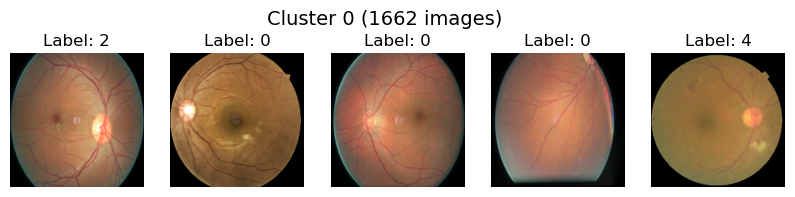

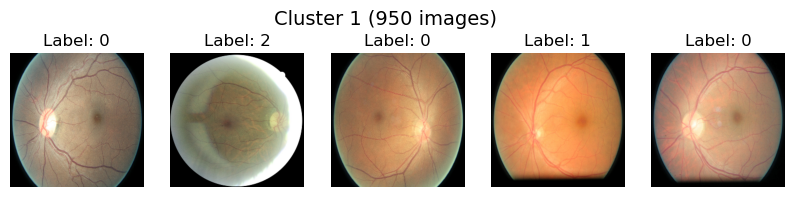

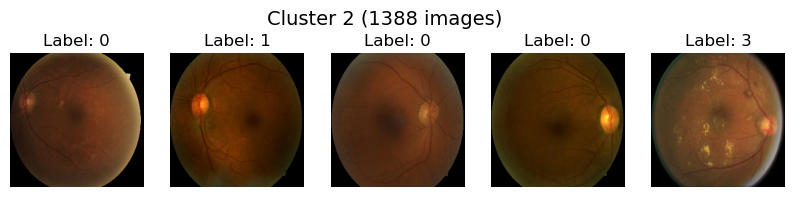

In [231]:
#affichage clusters
import matplotlib.pyplot as plt
import random
import numpy as np

n_clusters = len(np.unique(seq_cust_kmeans.labels_ ))

for cluster in range(n_clusters):
    cluster_indices = np.where(seq_cust_kmeans.labels_ == cluster)[0]
    if len(cluster_indices) == 0:
        print(f"⚠️ Cluster {cluster} is empty — no images assigned.")
        continue

    n_samples = min(5, len(cluster_indices))
    sample_indices = random.sample(list(cluster_indices), n_samples)

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        # Convert one-hot encoded label to class index
        label_value = np.argmax(labels[idx])

        plt.title(f"Label: {label_value}")
    plt.suptitle(f"Cluster {cluster} ({len(cluster_indices)} images)", fontsize=14, y=1.05)
    plt.show()

ray

In [18]:
import numpy as np
import ray
import time

@ray.remote
class Worker:
    """Ray worker for distributed K-Means computation"""

    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def compute_distances_and_assign(self, X_chunk, centroids):
        """
        Memory-efficient distance computation using batch processing
        """
        import gc
        
        t_start = time.time()
        
        centroids = np.array(centroids)
        X_chunk = np.array(X_chunk)
        
        n_samples = X_chunk.shape[0]
        labels = np.zeros(n_samples, dtype=int)
        
        # Process in batches to avoid large intermediate arrays
        batch_size = min(1000, n_samples)
        
        t_distance_start = time.time()
        for i in range(0, n_samples, batch_size):
            batch = X_chunk[i:i+batch_size]
            
            # Compute distances for this batch only
            distances = np.sqrt(((batch[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
            labels[i:i+batch_size] = np.argmin(distances, axis=1)
            
            del distances
            gc.collect()
        
        t_distance_end = time.time()

        # Compute partial sums and counts for each cluster
        t_aggregation_start = time.time()
        partial_sums = np.zeros((self.n_clusters, X_chunk.shape[1]))
        counts = np.zeros(self.n_clusters, dtype=int)

        for k in range(self.n_clusters):
            mask = labels == k
            counts[k] = np.sum(mask)
            if counts[k] > 0:
                partial_sums[k] = X_chunk[mask].sum(axis=0)
        
        t_aggregation_end = time.time()
        t_total = t_aggregation_end - t_start
        
        print(f'Worker - Distance computation: {t_distance_end-t_distance_start:.3f}s | '
              f'Aggregation: {t_aggregation_end-t_aggregation_start:.3f}s | '
              f'Total: {t_total:.3f}s')

        return labels, partial_sums, counts



class K_Means_Distributed:
    """Distributed K-Means using Ray for parallel computation"""

    def __init__(self, n_clusters, max_iter=300, tol=1e-4, num_workers=4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.num_workers = num_workers
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Initialize centroids to zero"""
        return np.zeros((self.n_clusters, X.shape[1]))

    def fit(self, X):
        """Train distributed K-Means on data X"""
        t_fit_start = time.time()
        
        X = np.array(X)

        # Create workers
        t_worker_start = time.time()
        workers = [Worker.remote(self.n_clusters) for _ in range(self.num_workers)]
        t_worker_end = time.time()
        #print(f'\n=== Setup ===')
        #print(f'Worker creation: {t_worker_end-t_worker_start:.3f}s')

        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        # Split data into chunks for workers
        t_split_start = time.time()
        X_chunks = np.array_split(X, self.num_workers)
        chunk_refs = [ray.put(chunk) for chunk in X_chunks]
        t_split_end = time.time()
        print(f'Data splitting & Ray.put: {t_split_end-t_split_start:.3f}s')
        
        # Timing collectors
        collect_it = []
        dispatch_times = []
        aggregation_times = []
        centroid_update_times = []
        convergence_check_times = []

        print(f'\n=== Training Started ===')
        for iteration in range(self.max_iter):
            print(f'\n--- Iteration {iteration + 1} ---')
            
            # Distribute work: compute distances and assign clusters
            t_dispatch_start = time.time()
            futures = [
                worker.compute_distances_and_assign.remote(chunk_ref, self.cluster_centers_)
                for worker, chunk_ref in zip(workers, chunk_refs)
            ]
            t_dispatch_end = time.time()
            dispatch_times.append(t_dispatch_end - t_dispatch_start)
            
            # Wait for results (this is where parallel work happens)
            t_collect_start = time.time()
            results = ray.get(futures)
            t_collect_end = time.time()
            collect_time = t_collect_end - t_collect_start
            collect_it.append(collect_time)
            print(f'Ray.get (collection): {collect_time:.3f}s')

            # Aggregate results from all workers
            t_agg_start = time.time()
            all_labels = []
            total_sums = np.zeros((self.n_clusters, X.shape[1]))
            total_counts = np.zeros(self.n_clusters, dtype=int)

            for labels_chunk, partial_sums, counts in results:
                all_labels.extend(labels_chunk)
                total_sums += partial_sums
                total_counts += counts

            self.labels_ = np.array(all_labels)
            t_agg_end = time.time()
            aggregation_times.append(t_agg_end - t_agg_start)
            print(f'Result aggregation: {t_agg_end-t_agg_start:.3f}s')

            # Compute new centroids from aggregated data
            t_centroid_start = time.time()
            new_centers = np.zeros((self.n_clusters, X.shape[1]))
            for k in range(self.n_clusters):
                if total_counts[k] > 0:
                    new_centers[k] = total_sums[k] / total_counts[k]
                else:
                    # Handle empty cluster - reinitialize randomly
                    new_centers[k] = X[k % X.shape[0]]
            t_centroid_end = time.time()
            centroid_update_times.append(t_centroid_end - t_centroid_start)
            print(f'Centroid update: {t_centroid_end-t_centroid_start:.3f}s')

            # Check convergence
            t_conv_start = time.time()
            if self.tol is not None:
                center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())
                self.cluster_centers_ = new_centers
                t_conv_end = time.time()
                convergence_check_times.append(t_conv_end - t_conv_start)
                print(f'Convergence check: {t_conv_end-t_conv_start:.3f}s | Center shift: {center_shift:.6f}')

                if center_shift < self.tol:
                    self.number_of_iter = iteration + 1
                    print(f'\n✓ Converged after {iteration + 1} iterations')
                    break
            else:
                self.cluster_centers_ = new_centers
                t_conv_end = time.time()
                convergence_check_times.append(t_conv_end - t_conv_start)
        else:
            self.number_of_iter = self.max_iter
            print(f'\n⚠ Max iterations ({self.max_iter}) reached')

        t_fit_end = time.time()
        
        # Print summary
        print(f'\n=== Training Summary ===')
        print(f'Total training time: {t_fit_end-t_fit_start:.3f}s')
        print(f'Number of iterations: {self.number_of_iter}')
        print(f'\nCollection times per iteration: {[f"{t:.3f}s" for t in collect_it]}')
        print(f'Average collection time: {np.mean(collect_it):.3f}s')
        print(f'Somme collection time: {np.sum(collect_it):.3f}s')
        print(f'Average dispatch time: {np.mean(dispatch_times):.3f}s')
        print(f'Average aggregation time: {np.mean(aggregation_times):.3f}s')
        print(f'Average centroid update time: {np.mean(centroid_update_times):.3f}s')
        print(f'Average convergence check time: {np.mean(convergence_check_times):.3f}s')

        return self

    def predict(self, X):
        """Predict cluster labels for new data (non-distributed for simplicity)"""
        X = np.array(X)
        distances = np.sqrt(((X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :]) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        """Fit and return cluster labels"""
        self.fit(X)
        return self.labels_

In [19]:
import time
import os
# ENABLE memory monitoring (don't set to 0!)
os.environ['RAY_memory_usage_threshold'] = '0.97'
os.environ['RAY_memory_monitor_refresh_ms'] = '250'  # Check every 250ms
# Shutdown if already running
if ray.is_initialized():
    ray.shutdown()
    
ray.init(num_cpus= 12)
print(ray.cluster_resources())
debut = time.time()
kmeans_dist = K_Means_Distributed(n_clusters=3, max_iter=500, num_workers=12)
kmeans_dist.fit(images_flat)
fin = time.time()
print(f'temps d entrainement = {fin-debut:.2f} secondes')

2025-11-12 10:47:39,184	INFO worker.py:2013 -- Started a local Ray instance.


{'CPU': 12.0, 'memory': 20884386612.0, 'object_store_memory': 8950451404.0, 'node:__internal_head__': 1.0, 'node:192.168.62.206': 1.0}
Data splitting & Ray.put: 0.536s

=== Training Started ===

--- Iteration 1 ---
(Worker pid=192124) Worker - Distance computation: 0.618s | Aggregation: 0.106s | Total: 0.798s
Ray.get (collection): 1.445s
Result aggregation: 0.020s
Centroid update: 0.004s
Convergence check: 0.003s | Center shift: 234.097367

--- Iteration 2 ---
Ray.get (collection): 1.748s
Result aggregation: 0.017s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 50.557266

--- Iteration 3 ---
Ray.get (collection): 1.748s
Result aggregation: 0.013s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 20.104090

--- Iteration 4 ---
(Worker pid=192120) Worker - Distance computation: 1.343s | Aggregation: 0.084s | Total: 1.581s [repeated 36x across cluster]
Ray.get (collection): 1.688s
Result aggregation: 0.013s
Centroid update: 0.003s
Convergence check: 0.00

In [20]:
ray.shutdown()

In [154]:
#list ray threads = [2, 4, 6, 8, 10, 12] 
#ray_threads2000 = []
ray_threads2000.append(fin-debut)

In [ ]:
ray_threads4000

In [180]:
ray_threads3000

[97.02015137672424,
 45.90068292617798,
 49.42057919502258,
 66.70830178260803,
 67.14582443237305,
 96.94667267799377]

In [155]:
ray_threads2000

[131.1574902534485,
 71.93559432029724,
 57.09832763671875,
 55.06694936752319,
 53.01991844177246,
 54.3138325214386]

In [64]:
ray_threads1000

[61.354700803756714,
 39.73122215270996,
 36.42682218551636,
 37.43852257728577,
 40.88112020492554,
 39.558454275131226]

In [156]:
ray.shutdown()

dask

In [33]:
import numpy as np
from dask.distributed import Client
import time

def _worker_compute(chunk, centroids):
    """
    Pure-Python worker function (runs on worker).
    Returns: labels (np.ndarray), partial_sums (np.ndarray), counts (np.ndarray)
    """
    t_start = time.time()
    
    chunk = np.array(chunk)
    centroids = np.array(centroids)

    # distances: (n_points_in_chunk, n_clusters)
    t_distance_start = time.time()
    distances = np.sqrt(((chunk[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    t_distance_end = time.time()

    n_clusters = centroids.shape[0]
    partial_sums = np.zeros((n_clusters, chunk.shape[1]))
    counts = np.zeros(n_clusters, dtype=int)

    t_aggregation_start = time.time()
    for k in range(n_clusters):
        mask = labels == k
        counts[k] = mask.sum()
        if counts[k] > 0:
            partial_sums[k] = chunk[mask].sum(axis=0)
    t_aggregation_end = time.time()
    
    t_total = t_aggregation_end - t_start
    
    #print(f'Worker - Distance computation: {t_distance_end-t_distance_start:.3f}s | '
          #f'Aggregation: {t_aggregation_end-t_aggregation_start:.3f}s | '
          #f'Total: {t_total:.3f}s')

    return labels, partial_sums, counts


class KMeansDistributedDask:
    """
    Distributed KMeans using dask.distributed futures (scatter / submit / gather).
    Caller should create a dask Client before calling fit(), e.g.:
        client = Client()  # or Client(<scheduler-address>)
    """
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, n_workers=4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.n_workers = n_workers
        self.random_state = random_state

        self.cluster_centers_ = None
        self.labels_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Initialize centroids to zero"""
        return np.zeros((self.n_clusters, X.shape[1]))

    def fit(self, X, client: Client):
        """
        Fit KMeans using an existing dask.distributed Client.
        - X: array-like (n_samples, n_features)
        - client: dask.distributed.Client (must be running)
        """
        t_fit_start = time.time()
        
        X = np.array(X)
        n_samples, n_features = X.shape

        # initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        # split and scatter data chunks to workers
        print(f'\n=== Setup ===')
        t_split_start = time.time()
        X_chunks = np.array_split(X, self.n_workers)
        t_split_end = time.time()
        print(f'Data splitting: {t_split_end-t_split_start:.3f}s')
        
        t_scatter_start = time.time()
        scattered = client.scatter(X_chunks, broadcast=False)
        t_scatter_end = time.time()
        print(f'Scatter to workers: {t_scatter_end-t_scatter_start:.3f}s')
        
        # Timing collectors
        submit_times = []
        gather_times = []
        aggregation_times = []
        centroid_update_times = []
        convergence_check_times = []

        print(f'\n=== Training Started ===')
        for iteration in range(self.max_iter):
            print(f'\n--- Iteration {iteration + 1} ---')
            
            # Submit jobs for each chunk
            t_submit_start = time.time()
            futures = [
                client.submit(_worker_compute, chunk_future, self.cluster_centers_)
                for chunk_future in scattered
            ]
            t_submit_end = time.time()
            submit_time = t_submit_end - t_submit_start
            submit_times.append(submit_time)
            print(f'Submit tasks: {submit_time:.3f}s')

            # Wait and gather results (this is where parallel work happens)
            t_gather_start = time.time()
            results = client.gather(futures)
            t_gather_end = time.time()
            gather_time = t_gather_end - t_gather_start
            gather_times.append(gather_time)
            print(f'Gather results: {gather_time:.3f}s')

            # Aggregate results
            t_agg_start = time.time()
            all_labels = []
            total_sums = np.zeros((self.n_clusters, n_features))
            total_counts = np.zeros(self.n_clusters, dtype=int)

            for labels_chunk, partial_sums, counts in results:
                all_labels.extend(labels_chunk.tolist() if isinstance(labels_chunk, np.ndarray) else labels_chunk)
                total_sums += partial_sums
                total_counts += counts

            self.labels_ = np.array(all_labels)
            t_agg_end = time.time()
            aggregation_times.append(t_agg_end - t_agg_start)
            print(f'Result aggregation: {t_agg_end-t_agg_start:.3f}s')

            # Compute new centers
            t_centroid_start = time.time()
            new_centers = np.zeros((self.n_clusters, n_features))
            for k in range(self.n_clusters):
                if total_counts[k] > 0:
                    new_centers[k] = total_sums[k] / total_counts[k]
                else:
                    # reinit empty cluster
                    new_centers[k] = X[k % X.shape[0]]
            t_centroid_end = time.time()
            centroid_update_times.append(t_centroid_end - t_centroid_start)
            print(f'Centroid update: {t_centroid_end-t_centroid_start:.3f}s')

            # Compute centroid shift
            t_conv_start = time.time()
            center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())
            self.cluster_centers_ = new_centers
            t_conv_end = time.time()
            convergence_check_times.append(t_conv_end - t_conv_start)
            print(f'Convergence check: {t_conv_end-t_conv_start:.3f}s | Center shift: {center_shift:.6f}')

            if center_shift < self.tol:
                self.number_of_iter = iteration + 1
                print(f'\n✓ Converged after {iteration + 1} iterations')
                break
        else:
            self.number_of_iter = self.max_iter
            print(f'\n⚠ Max iterations ({self.max_iter}) reached')

        t_fit_end = time.time()
        
        # Print summary
        print(f'\n=== Training Summary ===')
        print(f'Total training time: {t_fit_end-t_fit_start:.3f}s')
        print(f'Number of iterations: {self.number_of_iter}')
        print(f'\nSubmit times per iteration: {[f"{t:.3f}s" for t in submit_times]}')
        print(f'Somme submit time: {np.sum(submit_times):.3f}s')
        print(f'\nGather times per iteration: {[f"{t:.3f}s" for t in gather_times]}')
        print(f'Somme gather time: {np.sum(gather_times):.3f}s')
        print(f'\nSomme aggregation time: {np.sum(aggregation_times):.3f}s')
        print(f'Somme centroid update time: {np.sum(centroid_update_times):.3f}s')
        print(f'Somme convergence check time: {np.sum(convergence_check_times):.3f}s')
        
        # Breakdown of time spent
        total_submit = sum(submit_times)
        total_gather = sum(gather_times)
        total_agg = sum(aggregation_times)
        total_centroid = sum(centroid_update_times)
        total_conv = sum(convergence_check_times)
        total_iteration = total_submit + total_gather + total_agg + total_centroid + total_conv
        
        print(f'\n=== Time Breakdown ===')
        print(f'Submit tasks: {total_submit:.3f}s ({100*total_submit/total_iteration:.1f}%)')
        print(f'Gather (parallel work): {total_gather:.3f}s ({100*total_gather/total_iteration:.1f}%)')
        print(f'Aggregation: {total_agg:.3f}s ({100*total_agg/total_iteration:.1f}%)')
        print(f'Centroid updates: {total_centroid:.3f}s ({100*total_centroid/total_iteration:.1f}%)')
        print(f'Convergence checks: {total_conv:.3f}s ({100*total_conv/total_iteration:.1f}%)')

        return self

    def predict(self, X):
        X = np.array(X)
        distances = np.sqrt(((X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :]) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def fit_predict(self, X, client: Client):
        self.fit(X, client)
        return self.labels_

In [34]:
client.close()
print("Starting Dask Client...")
client = Client(n_workers=1, threads_per_worker=12)
print(f"Dask Dashboard: {client.dashboard_link}")

Starting Dask Client...
Dask Dashboard: http://127.0.0.1:8787/status


In [35]:
import time
start = time.time()
kmeans_dask = KMeansDistributedDask(n_clusters=3, max_iter=500, n_workers=12)
kmeans_dask.fit(images_flat, client)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")
print(f"Iterations: {kmeans_dask.number_of_iter}")


=== Setup ===
Data splitting: 0.000s
Scatter to workers: 3.997s

=== Training Started ===

--- Iteration 1 ---
Submit tasks: 0.406s
Gather results: 1.505s
Result aggregation: 0.017s
Centroid update: 0.003s
Convergence check: 0.004s | Center shift: 234.097367

--- Iteration 2 ---
Submit tasks: 0.341s
Gather results: 1.463s
Result aggregation: 0.015s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 50.557266

--- Iteration 3 ---
Submit tasks: 0.359s
Gather results: 1.452s
Result aggregation: 0.013s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 20.104090

--- Iteration 4 ---
Submit tasks: 0.253s
Gather results: 1.605s
Result aggregation: 0.013s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 15.303677

--- Iteration 5 ---
Submit tasks: 0.266s
Gather results: 1.417s
Result aggregation: 0.014s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 9.711925

--- Iteration 6 ---
Submit tasks: 0.245s
Gather results: 1.455s
Resu

In [188]:
#list dask threads = [2, 4, 6, 8, 10, 12] 
#dask_threads2000 = []
dask_threads2000.append(end-start)

In [221]:
dask_threads3000

[143.23429560661316,
 112.72734189033508,
 84.83199691772461,
 84.93274354934692,
 74.30208683013916,
 96.00429081916809]

In [189]:
dask_threads2000

[140.75279307365417,
 82.39594388008118,
 69.68497920036316,
 65.79904365539551,
 68.84986424446106,
 70.41226935386658]

In [94]:
dask_threads1000

[67.80903816223145,
 45.483147621154785,
 38.40120768547058,
 40.179677963256836,
 41.91077780723572,
 45.154486417770386]

In [36]:
client.close()

In [39]:
import numpy as np
from multiprocessing import Pool, cpu_count, shared_memory
import ctypes
import time


def _worker_compute_shared(args):
    t_start = time.time()
    
    shm_name, shape, dtype, start_idx, end_idx, centroids, n_clusters = args

    # Attach to existing shared memory
    shm = shared_memory.SharedMemory(name=shm_name)
    X_shared = np.ndarray(shape, dtype=dtype, buffer=shm.buf)

    # Work on assigned slice
    X_chunk = X_shared[start_idx:end_idx]
    centroids = np.array(centroids)

    # Vectorized distance computation
    t_distance_start = time.time()
    distances = np.sqrt(((X_chunk[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    t_distance_end = time.time()

    # Compute partial sums and counts for each cluster
    t_aggregation_start = time.time()
    partial_sums = np.zeros((n_clusters, X_chunk.shape[1]))
    counts = np.zeros(n_clusters, dtype=int)

    for k in range(n_clusters):
        mask = labels == k
        counts[k] = np.sum(mask)
        if counts[k] > 0:
            partial_sums[k] = X_chunk[mask].sum(axis=0)
    t_aggregation_end = time.time()

    # Clean up (don't unlink - just detach)
    shm.close()
    
    t_total = t_aggregation_end - t_start

    return labels, partial_sums, counts


class KMeansMultiprocessing:

    def __init__(self, n_clusters, max_iter=300, tol=1e-4, n_workers=None,
                 random_state=None, verbose=True, use_shared_memory=True):

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.n_workers = n_workers if n_workers is not None else cpu_count()
        self.random_state = random_state
        self.verbose = verbose
        self.use_shared_memory = use_shared_memory

        self.cluster_centers_ = None
        self.labels_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Initialize centroids to zero"""
        return np.zeros((self.n_clusters, X.shape[1]))

    def _fit_shared_memory(self, X):
        """Fit using shared memory (memory efficient)"""
        t_fit_start = time.time()
        
        n_samples, n_features = X.shape

        print(f'\n=== Setup ===')
        # Create shared memory block
        t_shm_start = time.time()
        shm = shared_memory.SharedMemory(create=True, size=X.nbytes)
        X_shared = np.ndarray(X.shape, dtype=X.dtype, buffer=shm.buf)
        X_shared[:] = X[:]  # Copy data once into shared memory
        t_shm_end = time.time()
        print(f'Shared memory creation and data copy: {t_shm_end-t_shm_start:.3f}s')

        # Calculate chunk boundaries (indices instead of copying data)
        t_split_start = time.time()
        chunk_sizes = [len(chunk) for chunk in np.array_split(range(n_samples), self.n_workers)]
        chunk_indices = []
        start_idx = 0
        for size in chunk_sizes:
            end_idx = start_idx + size
            chunk_indices.append((start_idx, end_idx))
            start_idx = end_idx
        t_split_end = time.time()
        print(f'Chunk boundary calculation: {t_split_end-t_split_start:.3f}s')

        # Timing collectors
        iteration_total_times = []
        args_prep_times = []
        map_times = []
        aggregation_times = []
        centroid_update_times = []
        convergence_check_times = []
        iteration_overhead_times = []

        try:
            with Pool(processes=self.n_workers) as pool:
                print(f'\n=== Training Started ===')
                for iteration in range(self.max_iter):
                    t_iteration_start = time.time()
                    
                    if self.verbose:
                        print(f'\n--- Iteration {iteration + 1} ---')
                    
                    # Prepare arguments: each worker gets indices, not data
                    t_args_start = time.time()
                    args_list = [
                        (shm.name, X.shape, X.dtype, start_idx, end_idx,
                         self.cluster_centers_, self.n_clusters)
                        for start_idx, end_idx in chunk_indices
                    ]
                    t_args_end = time.time()
                    args_prep_time = t_args_end - t_args_start
                    args_prep_times.append(args_prep_time)
                    if self.verbose:
                        print(f'Arguments preparation: {args_prep_time:.3f}s')

                    # Distribute work
                    t_map_start = time.time()
                    results = pool.map(_worker_compute_shared, args_list)
                    t_map_end = time.time()
                    map_time = t_map_end - t_map_start
                    map_times.append(map_time)
                    if self.verbose:
                        print(f'Parallel computation (pool.map): {map_time:.3f}s')

                    # Aggregate results
                    t_agg_start = time.time()
                    all_labels = []
                    total_sums = np.zeros((self.n_clusters, n_features))
                    total_counts = np.zeros(self.n_clusters, dtype=int)

                    for labels_chunk, partial_sums, counts in results:
                        all_labels.extend(labels_chunk)
                        total_sums += partial_sums
                        total_counts += counts

                    self.labels_ = np.array(all_labels)
                    t_agg_end = time.time()
                    aggregation_time = t_agg_end - t_agg_start
                    aggregation_times.append(aggregation_time)
                    if self.verbose:
                        print(f'Result aggregation: {aggregation_time:.3f}s')

                    # Compute new centroids
                    t_centroid_start = time.time()
                    new_centers = np.zeros((self.n_clusters, n_features))
                    for k in range(self.n_clusters):
                        if total_counts[k] > 0:
                            new_centers[k] = total_sums[k] / total_counts[k]
                        else:
                            # Deterministic handling of empty clusters
                            new_centers[k] = X[k % n_samples]  # Use k-th point instead of random
                    t_centroid_end = time.time()
                    centroid_time = t_centroid_end - t_centroid_start
                    centroid_update_times.append(centroid_time)
                    if self.verbose:
                        print(f'Centroid update: {centroid_time:.3f}s')

                    # Check convergence
                    t_conv_start = time.time()
                    center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())
                    self.cluster_centers_ = new_centers
                    t_conv_end = time.time()
                    convergence_time = t_conv_end - t_conv_start
                    convergence_check_times.append(convergence_time)
                    if self.verbose:
                        print(f'Convergence check: {convergence_time:.3f}s | Center shift: {center_shift:.6f}')

                    # Calculate iteration overhead (time not accounted for)
                    t_iteration_end = time.time()
                    iteration_total = t_iteration_end - t_iteration_start
                    iteration_total_times.append(iteration_total)
                    
                    accounted_time = args_prep_time + map_time + aggregation_time + centroid_time + convergence_time
                    overhead = iteration_total - accounted_time
                    iteration_overhead_times.append(overhead)
                    
                    if self.verbose:
                        print(f'Iteration overhead (print, misc): {overhead:.3f}s')
                        print(f'Total iteration time: {iteration_total:.3f}s')

                    if center_shift < self.tol:
                        self.number_of_iter = iteration + 1
                        if self.verbose:
                            print(f'\n✓ Converged after {iteration + 1} iterations')
                        break
                else:
                    self.number_of_iter = self.max_iter
                    if self.verbose:
                        print(f'\n⚠ Max iterations ({self.max_iter}) reached')
        finally:
            # Clean up shared memory
            t_cleanup_start = time.time()
            shm.close()
            shm.unlink()
            t_cleanup_end = time.time()
            if self.verbose:
                print(f'\nShared memory cleanup: {t_cleanup_end-t_cleanup_start:.3f}s')

        t_fit_end = time.time()
        
        if self.verbose:
            # Print summary
            print(f'\n=== Training Summary ===')
            print(f'Total training time: {t_fit_end-t_fit_start:.3f}s')
            print(f'Number of iterations: {self.number_of_iter}')
            
            print(f'\nArguments prep times per iteration: {[f"{t:.3f}s" for t in args_prep_times]}')
            print(f'Sum args prep time: {np.sum(args_prep_times):.3f}s')
            
            print(f'\nMap times per iteration: {[f"{t:.3f}s" for t in map_times]}')
            print(f'Sum map time: {np.sum(map_times):.3f}s')
            
            print(f'\nSum aggregation time: {np.sum(aggregation_times):.3f}s')
            print(f'Sum centroid update time: {np.sum(centroid_update_times):.3f}s')
            print(f'Sum convergence check time: {np.sum(convergence_check_times):.3f}s')
            print(f'Sum iteration overhead time: {np.sum(iteration_overhead_times):.3f}s')
            
            # Breakdown of time spent
            total_args_prep = sum(args_prep_times)
            total_map = sum(map_times)
            total_agg = sum(aggregation_times)
            total_centroid = sum(centroid_update_times)
            total_conv = sum(convergence_check_times)
            total_overhead = sum(iteration_overhead_times)
            total_iteration = total_args_prep + total_map + total_agg + total_centroid + total_conv + total_overhead
            
            print(f'\n=== Time Breakdown ===')
            print(f'Arguments preparation: {total_args_prep:.3f}s ({100*total_args_prep/total_iteration:.1f}%)')
            print(f'Parallel computation: {total_map:.3f}s ({100*total_map/total_iteration:.1f}%)')
            print(f'Aggregation: {total_agg:.3f}s ({100*total_agg/total_iteration:.1f}%)')
            print(f'Centroid updates: {total_centroid:.3f}s ({100*total_centroid/total_iteration:.1f}%)')
            print(f'Convergence checks: {total_conv:.3f}s ({100*total_conv/total_iteration:.1f}%)')
            print(f'Iteration overhead (print, misc): {total_overhead:.3f}s ({100*total_overhead/total_iteration:.1f}%)')
            
            # Verification
            print(f'\n=== Verification ===')
            print(f'Sum of all measured times: {total_iteration:.3f}s')
            print(f'Actual total training time: {t_fit_end-t_fit_start:.3f}s')
            print(f'Setup + cleanup time: {(t_shm_end-t_shm_start) + (t_split_end-t_split_start) + (t_cleanup_end-t_cleanup_start):.3f}s')
            print(f'Expected total: {total_iteration + (t_shm_end-t_shm_start) + (t_split_end-t_split_start) + (t_cleanup_end-t_cleanup_start):.3f}s')

    def fit(self, X):
        X = np.array(X)

        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        # Choose fitting method based on use_shared_memory flag
        self._fit_shared_memory(X)

        return self

In [40]:
import time
debut = time.time()
kmeans_mult = KMeansMultiprocessing(n_clusters= 3, max_iter=300, n_workers=12, use_shared_memory=True)
kmeans_mult.fit(images_flat)
fin = time.time()
print(f'temps d entrainement = {fin-debut:.2f} secondes')



=== Setup ===
Shared memory creation and data copy: 1.483s
Chunk boundary calculation: 0.001s

=== Training Started ===

--- Iteration 1 ---
Arguments preparation: 0.000s
Parallel computation (pool.map): 2.468s
Result aggregation: 0.014s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 234.097367
Iteration overhead (print, misc): 0.001s
Total iteration time: 2.490s

--- Iteration 2 ---
Arguments preparation: 0.000s
Parallel computation (pool.map): 1.762s
Result aggregation: 0.019s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 50.557266
Iteration overhead (print, misc): 0.001s
Total iteration time: 1.788s

--- Iteration 3 ---
Arguments preparation: 0.000s
Parallel computation (pool.map): 1.740s
Result aggregation: 0.015s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 20.104090
Iteration overhead (print, misc): 0.001s
Total iteration time: 1.762s

--- Iteration 4 ---
Arguments preparation: 0.000s
Parallel computation (pool.map): 1.

In [204]:
#mult_threads = [2, 4, 6, 8, 12]
#mult_threads2000 = []
mult_threads2000.append(fin-debut)
mult_threads2000

[121.90708804130554,
 73.40440201759338,
 57.14369082450867,
 54.169450521469116,
 51.182063579559326,
 49.544926166534424]

In [193]:
mult_threads1000

[63.12885499000549,
 39.005995988845825,
 36.70881175994873,
 38.58267688751221,
 36.19013428688049,
 37.11656212806702]

In [41]:
import numpy as np
from parsl.app.app import python_app
from parsl.config import Config
from parsl.executors import ThreadPoolExecutor
import parsl
import time

@python_app
def compute_distances_and_assign(X_chunk, centroids, n_clusters):
    """
    Parsl app: Compute distances and assign clusters for a data chunk.
    Returns: labels, partial_sums, counts
    """
    import numpy as np
    import time
    
    t_start = time.time()

    X_chunk = np.array(X_chunk)
    centroids = np.array(centroids)

    # Vectorized distance computation
    t_distance_start = time.time()
    distances = np.sqrt(((X_chunk[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    t_distance_end = time.time()

    # Compute partial sums and counts for each cluster
    t_aggregation_start = time.time()
    partial_sums = np.zeros((n_clusters, X_chunk.shape[1]))
    counts = np.zeros(n_clusters, dtype=int)

    for k in range(n_clusters):
        mask = labels == k
        counts[k] = np.sum(mask)
        if counts[k] > 0:
            partial_sums[k] = X_chunk[mask].sum(axis=0)
    t_aggregation_end = time.time()
    
    t_total = t_aggregation_end - t_start

    return labels, partial_sums, counts


class KMeansDistributedParsl:

    def __init__(self, n_clusters, max_iter=300, tol=1e-4, n_workers=4, random_state=None, verbose=True):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.n_workers = n_workers
        self.random_state = random_state
        self.verbose = verbose

        self.cluster_centers_ = None
        self.labels_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Initialize centroids to zero"""
        return np.zeros((self.n_clusters, X.shape[1]))

    def fit(self, X):
        t_fit_start = time.time()

        X = np.array(X)
        n_samples, n_features = X.shape

        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        print(f'\n=== Setup ===')
        # Split data into chunks for parallel processing
        t_split_start = time.time()
        X_chunks = np.array_split(X, self.n_workers)
        t_split_end = time.time()
        print(f'Data splitting: {t_split_end-t_split_start:.3f}s')

        # Timing collectors
        iteration_total_times = []
        submit_times = []
        gather_times = []
        aggregation_times = []
        centroid_update_times = []
        convergence_check_times = []
        iteration_overhead_times = []

        print(f'\n=== Training Started ===')
        for iteration in range(self.max_iter):
            t_iteration_start = time.time()
            
            if self.verbose:
                print(f'\n--- Iteration {iteration + 1} ---')

            # Submit parallel tasks - one per chunk
            t_submit_start = time.time()
            futures = [
                compute_distances_and_assign(
                    chunk,
                    self.cluster_centers_,
                    self.n_clusters
                )
                for chunk in X_chunks
            ]
            t_submit_end = time.time()
            submit_time = t_submit_end - t_submit_start
            submit_times.append(submit_time)
            if self.verbose:
                print(f'Submit tasks: {submit_time:.3f}s')

            # Wait for all tasks to complete and gather results
            t_gather_start = time.time()
            results = [future.result() for future in futures]
            t_gather_end = time.time()
            gather_time = t_gather_end - t_gather_start
            gather_times.append(gather_time)
            if self.verbose:
                print(f'Gather results (parallel work): {gather_time:.3f}s')

            # Aggregate results from all workers
            t_agg_start = time.time()
            all_labels = []
            total_sums = np.zeros((self.n_clusters, n_features))
            total_counts = np.zeros(self.n_clusters, dtype=int)

            for labels_chunk, partial_sums, counts in results:
                labels_chunk = np.array(labels_chunk)
                partial_sums = np.array(partial_sums)
                counts = np.array(counts)

                all_labels.extend(labels_chunk.tolist())
                total_sums += partial_sums
                total_counts += counts

            self.labels_ = np.array(all_labels)
            t_agg_end = time.time()
            aggregation_time = t_agg_end - t_agg_start
            aggregation_times.append(aggregation_time)
            if self.verbose:
                print(f'Result aggregation: {aggregation_time:.3f}s')

            # Compute new centroids from aggregated data
            t_centroid_start = time.time()
            new_centers = np.zeros((self.n_clusters, n_features))
            for k in range(self.n_clusters):
                if total_counts[k] > 0:
                    new_centers[k] = total_sums[k] / total_counts[k]
                else:
                    # Handle empty cluster 
                    new_centers[k] = X[k % X.shape[0]]  # Deterministic
            t_centroid_end = time.time()
            centroid_time = t_centroid_end - t_centroid_start
            centroid_update_times.append(centroid_time)
            if self.verbose:
                print(f'Centroid update: {centroid_time:.3f}s')

            # Check convergence
            t_conv_start = time.time()
            center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())
            self.cluster_centers_ = new_centers
            t_conv_end = time.time()
            convergence_time = t_conv_end - t_conv_start
            convergence_check_times.append(convergence_time)
            if self.verbose:
                print(f'Convergence check: {convergence_time:.3f}s | Center shift: {center_shift:.6f}')

            # Calculate iteration overhead
            t_iteration_end = time.time()
            iteration_total = t_iteration_end - t_iteration_start
            iteration_total_times.append(iteration_total)
            
            accounted_time = submit_time + gather_time + aggregation_time + centroid_time + convergence_time
            overhead = iteration_total - accounted_time
            iteration_overhead_times.append(overhead)
            
            if self.verbose:
                print(f'Iteration overhead (print, misc): {overhead:.3f}s')
                print(f'Total iteration time: {iteration_total:.3f}s')

            if center_shift < self.tol:
                self.number_of_iter = iteration + 1
                if self.verbose:
                    print(f'\n✓ Converged after {iteration + 1} iterations')
                break
        else:
            self.number_of_iter = self.max_iter
            if self.verbose:
                print(f'\n⚠ Max iterations ({self.max_iter}) reached')

        t_fit_end = time.time()

        if self.verbose:
            # Print summary
            print(f'\n=== Training Summary ===')
            print(f'Total training time: {t_fit_end-t_fit_start:.3f}s')
            print(f'Number of iterations: {self.number_of_iter}')
            
            print(f'\nSubmit times per iteration: {[f"{t:.3f}s" for t in submit_times]}')
            print(f'Sum submit time: {np.sum(submit_times):.3f}s')
            
            print(f'\nGather times per iteration: {[f"{t:.3f}s" for t in gather_times]}')
            print(f'Sum gather time: {np.sum(gather_times):.3f}s')
            
            print(f'\nSum aggregation time: {np.sum(aggregation_times):.3f}s')
            print(f'Sum centroid update time: {np.sum(centroid_update_times):.3f}s')
            print(f'Sum convergence check time: {np.sum(convergence_check_times):.3f}s')
            print(f'Sum iteration overhead time: {np.sum(iteration_overhead_times):.3f}s')
            
            # Breakdown of time spent
            total_submit = sum(submit_times)
            total_gather = sum(gather_times)
            total_agg = sum(aggregation_times)
            total_centroid = sum(centroid_update_times)
            total_conv = sum(convergence_check_times)
            total_overhead = sum(iteration_overhead_times)
            total_iteration = total_submit + total_gather + total_agg + total_centroid + total_conv + total_overhead
            
            print(f'\n=== Time Breakdown ===')
            print(f'Submit tasks: {total_submit:.3f}s ({100*total_submit/total_iteration:.1f}%)')
            print(f'Gather (parallel work): {total_gather:.3f}s ({100*total_gather/total_iteration:.1f}%)')
            print(f'Aggregation: {total_agg:.3f}s ({100*total_agg/total_iteration:.1f}%)')
            print(f'Centroid updates: {total_centroid:.3f}s ({100*total_centroid/total_iteration:.1f}%)')
            print(f'Convergence checks: {total_conv:.3f}s ({100*total_conv/total_iteration:.1f}%)')
            print(f'Iteration overhead (print, misc): {total_overhead:.3f}s ({100*total_overhead/total_iteration:.1f}%)')
            
            # Verification
            print(f'\n=== Verification ===')
            print(f'Sum of all measured times: {total_iteration:.3f}s')
            print(f'Actual total training time: {t_fit_end-t_fit_start:.3f}s')
            print(f'Setup time: {t_split_end-t_split_start:.3f}s')
            print(f'Expected total: {total_iteration + (t_split_end-t_split_start):.3f}s')

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        X = np.array(X)
        distances = np.sqrt(((X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :]) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        """Fit and return cluster labels"""
        self.fit(X)
        return self.labels_

In [42]:
# Setup Parsl configuration
# Disable all parsl logging before loading
import logging
parsl.set_stream_logger(level=logging.CRITICAL)
config = Config(
        executors=[
                ThreadPoolExecutor(max_threads=12, label='local_threads')
         ],
    monitoring=None,  # Disable monitoring
    usage_tracking=False
    )
parsl.load(config)

# Create and fit model
import time
debut = time.time()
kmeans = KMeansDistributedParsl(n_clusters=3, n_workers=12)
kmeans.fit(images_flat)
fin = time.time()

print(f'temps d entrainement = {fin-debut:.2f} secondes')

# Clean up
parsl.clear()


=== Setup ===
Data splitting: 0.000s

=== Training Started ===

--- Iteration 1 ---
Submit tasks: 0.047s
Gather results (parallel work): 1.445s
Result aggregation: 0.043s
Centroid update: 0.002s
Convergence check: 0.003s | Center shift: 234.097367
Iteration overhead (print, misc): 0.001s
Total iteration time: 1.542s

--- Iteration 2 ---
Submit tasks: 0.031s
Gather results (parallel work): 1.915s
Result aggregation: 0.021s
Centroid update: 0.003s
Convergence check: 0.004s | Center shift: 50.557266
Iteration overhead (print, misc): 0.001s
Total iteration time: 1.975s

--- Iteration 3 ---
Submit tasks: 0.030s
Gather results (parallel work): 1.936s
Result aggregation: 0.021s
Centroid update: 0.003s
Convergence check: 0.003s | Center shift: 20.104090
Iteration overhead (print, misc): 0.001s
Total iteration time: 1.992s

--- Iteration 4 ---
Submit tasks: 0.041s
Gather results (parallel work): 1.811s
Result aggregation: 0.032s
Centroid update: 0.003s
Convergence check: 0.004s | Center shift:

In [218]:
#parsl_threads = [2, 4, 6, 8, 12]
#parsl_threads2000 = []
parsl_threads2000.append(fin-debut)
parsl_threads2000

[125.36005759239197,
 71.90390992164612,
 56.673627853393555,
 51.97989892959595,
 53.38015007972717,
 55.884387254714966]

In [207]:
parsl_threads1000

[57.80937361717224,
 34.724613189697266,
 29.82589077949524,
 26.226500511169434,
 24.55180859565735,
 26.14500093460083]